

## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [1]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
# Feel free to add more imports and global settings here, though none are necessary.
import math
from collections import defaultdict
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [2]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=11c4ff8a-72a8-432a-b86b-43caf332f8d7
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:01<00:00, 220MB/s]


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


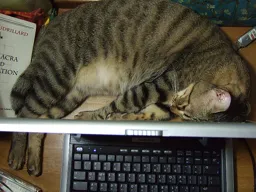

5 cat


In [3]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

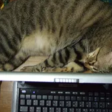

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-1.998..2.64
label=5 (cat)


In [4]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


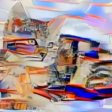

In [5]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [6]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [7]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [8]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [9]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [10]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    ### BEGIN SOLUTION

    num_selected_classes = len(SELECTED_CLASSES)
    new_layer = torch.nn.Linear(layer.in_features, num_selected_classes)

    new_weight = torch.zeros((num_selected_classes, layer.in_features), device=layer.weight.device)
    new_biass = torch.zeros(num_selected_classes, device=layer.bias.device)

    for imagenet_id, selected_id in id_map.items():
        # uniting imagenet_id class into selected_id class
        new_weight[selected_id] += layer.weight[imagenet_id]
        new_biass[selected_id] += layer.bias[imagenet_id]

    new_layer.weight.data = new_weight
    new_layer.bias.data = new_biass

    return new_layer

    ### END SOLUTION

In [11]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 74.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it, accuracy=87.3 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [13]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

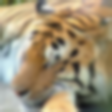

In [14]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

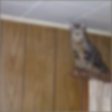

In [15]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape
    ### BEGIN SOLUTION

    # Gaussian blur

    sigma_min = 0.5
    sigma_max = 10.0
    sigma = sigma_min + (sigma_max - sigma_min) * (strength / 100.0)
    kernel_size = int(2 * math.ceil(3 * sigma) + 1)
    kernel_size = min(kernel_size, 31)
    if kernel_size % 2 == 0:
        kernel_size += 1

    coords = torch.arange(kernel_size, dtype=x.dtype, device=x.device) - kernel_size // 2
    gauss = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    gauss = gauss / gauss.sum()

    kernel_2d = gauss.unsqueeze(1) @ gauss.unsqueeze(0)
    kernel_2d = kernel_2d.expand(C, 1, kernel_size, kernel_size)

    padding = kernel_size // 2

    x = F.conv2d(x, weight=kernel_2d, bias=None, stride=1, padding=padding, groups=C)

    ### END SOLUTION
    return x


example_transformed(blur, 507)

In [16]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

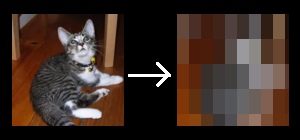

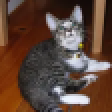

In [17]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    ### BEGIN SOLUTION
    *batch_dims, C, H, W = x.shape

    N = 1
    for d in batch_dims:
        N *= d
    x_reshaped = x.reshape(N, C, H, W)

    pad_h = (block_height - (H % block_height)) % block_height
    pad_w = (block_width - (W % block_width)) % block_width

    if pad_h > 0 or pad_w > 0:
        x_reshaped = F.pad(x_reshaped, (0, pad_w, 0, pad_h), mode='reflect')

    pooled = F.avg_pool2d(x_reshaped, kernel_size=(block_height, block_width), stride=(block_height, block_width))

    out = F.interpolate(pooled, size=(H + pad_h, W + pad_w), mode='nearest')

    if pad_h > 0 or pad_w > 0:
        out = out[..., :H, :W]

    out = out.reshape(*batch_dims, C, H, W)

    return out
    ### END SOLUTION

example_transformed(lambda x: pixelize(x, 2, 2), 510)

In [18]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

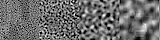

In [19]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 2) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."
    ### BEGIN SOLUTION

    # Gaussian noise

    *batch_dims, C, H, W = x.shape
    N = 1
    for d in batch_dims:
        N *= d

    x_reshaped = x.reshape(N, C, H, W)

    std = strength ** 2 * 0.001

    if grain_size > 1:
      downsampled_height = max(1, H // grain_size)
      downsampled_width = max(1, W // grain_size)
      noise_low = torch.randn(N, 1, downsampled_height, downsampled_width, device=x.device, dtype=x.dtype)
      noise = F.interpolate(noise_low, size=(H, W), mode='nearest')
      noise = noise.expand(-1, C, -1, -1)
    else:
      noise = torch.randn(N, 1, H, W, device=x.device, dtype=x.dtype)
      noise = noise.expand(-1, C, -1, -1)
    noise = noise * std
    x_noisy = x + noise
    out = x_noisy.reshape(*batch_dims, C, H, W)
    return out

    ### END SOLUTION

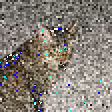

In [20]:
example_transformed(noise, 506)

In [21]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

eval: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, accuracy=87.3 %]


Baseline accuracy: 87.30%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it, accuracy=77.5 %]


Blur strength=5: 77.50%


eval: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it, accuracy=52.4 %]


Blur strength=25: 52.40%


eval: 100%|██████████| 4/4 [00:30<00:00,  7.58s/it, accuracy=31.5 %]


Blur strength=50: 31.50%


eval: 100%|██████████| 4/4 [00:29<00:00,  7.40s/it, accuracy=23.7 %]


Blur strength=75: 23.70%


eval: 100%|██████████| 4/4 [00:28<00:00,  7.10s/it, accuracy=21.7 %]


Blur strength=85: 21.70%


eval: 100%|██████████| 4/4 [00:28<00:00,  7.08s/it, accuracy=22.0 %]


Blur strength=100: 22.00%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, accuracy=44.4 %]


Pixelize 2x2: 44.40%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it, accuracy=30.2 %]


Pixelize 4x4: 30.20%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, accuracy=28.1 %]


Pixelize 4x6: 28.10%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, accuracy=25.6 %]


Pixelize 6x4: 25.60%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it, accuracy=23.3 %]


Pixelize 8x8: 23.30%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, accuracy=19.9 %]


Pixelize 16x16: 19.90%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, accuracy=13.9 %]


Pixelize 25x12: 13.90%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it, accuracy=14.1 %]


Pixelize 25x25: 14.10%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, accuracy=11.5 %]


Pixelize 50x50: 11.50%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, accuracy=84.1 %]


Noise strength=10, grain_size=5: 84.10%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, accuracy=42.0 %]


Noise strength=25, grain_size=5: 42.00%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, accuracy=10.8 %]


Noise strength=50, grain_size=5: 10.80%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, accuracy=11.1 %]


Noise strength=100, grain_size=5: 11.10%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, accuracy=85.2 %]


Noise strength=10, grain_size=10: 85.20%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it, accuracy=47.8 %]


Noise strength=25, grain_size=10: 47.80%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, accuracy=9.8 %]


Noise strength=50, grain_size=10: 9.80%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, accuracy=11.9 %]


Noise strength=100, grain_size=10: 11.90%


eval: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it, accuracy=85.5 %]


Noise strength=10, grain_size=20: 85.50%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, accuracy=64.7 %]


Noise strength=25, grain_size=20: 64.70%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, accuracy=10.9 %]


Noise strength=50, grain_size=20: 10.90%


eval: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, accuracy=8.8 %]


Noise strength=100, grain_size=20: 8.80%


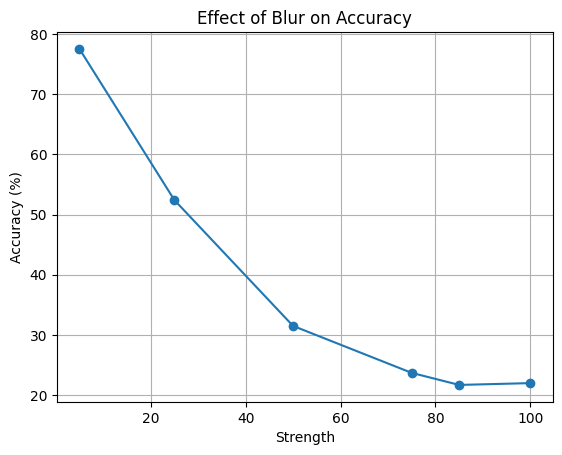

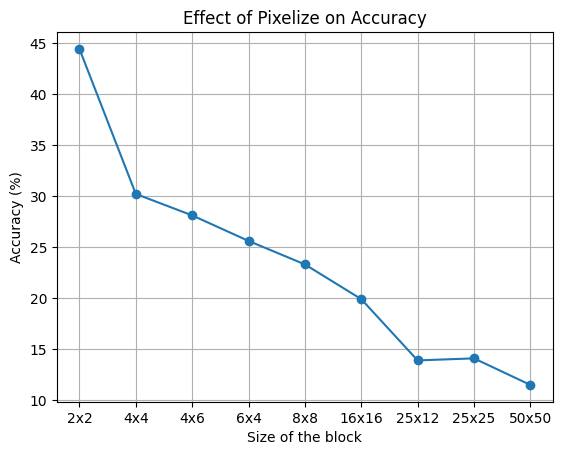

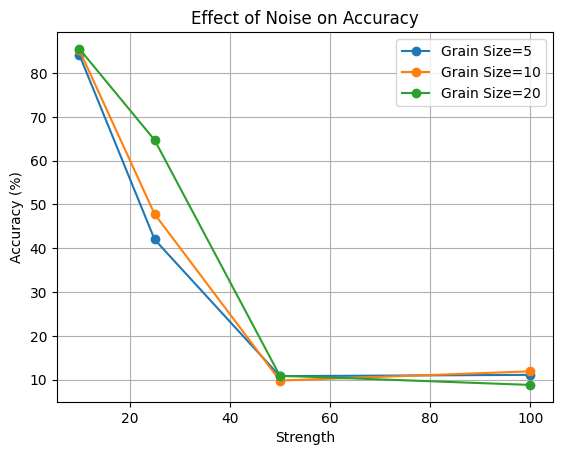

In [ ]:
### BEGIN SOLUTION ###
class WrapTransform(Dataset):
    def __init__(self, dataset: Dataset, transform: Callable[[torch.Tensor], torch.Tensor]):
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label

val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())

model = get_model(eval=True)

results = defaultdict(list)

# Baseline
baseline_acc = evaluate(model, val_dataset, use_workers=False)
print(f"Baseline accuracy: {baseline_acc*100:.2f}%")
results['Baseline'].append({'Parameter': 'Baseline', 'Accuracy': baseline_acc * 100})

# Blur transformation
blur_strengths = [5, 25, 50, 75, 85, 100]
for s in blur_strengths:
    blur_dataset = WrapTransform(val_dataset, lambda x: blur(x, strength=s))
    acc = evaluate(model, blur_dataset, use_workers=False)
    print(f"Blur strength={s}: {acc*100:.2f}%")
    results['Blur'].append({'Parameter': s, 'Accuracy': acc * 100})

# Pixelize transformation
pixel_blocks = [(2, 2), (4, 4), (4, 6), (6, 4), (8, 8), (16, 16), (25, 12), (25, 25), (50, 50)]
for (bh, bw) in pixel_blocks:
    pixel_dataset = WrapTransform(val_dataset, lambda x: pixelize(x, block_height=bh, block_width=bw))
    acc = evaluate(model, pixel_dataset, use_workers=False)
    print(f"Pixelize {bh}x{bw}: {acc*100:.2f}%")
    results['Pixelize'].append({'Parameter': f"{bh}x{bw}", 'Accuracy': acc * 100})

# Noise transformation
noise_parameters = [(10, 5), (25, 5), (50, 5), (100, 5), (10, 10), (25, 10), (50, 10), (100, 10), (10, 20), (25, 20), (50, 20), (100, 20)]
for (stren, grain) in noise_parameters:
    noise_dataset = WrapTransform(val_dataset, lambda x: noise(x, strength=stren, grain_size=grain))
    acc = evaluate(model, noise_dataset, use_workers=False)
    print(f"Noise strength={stren}, grain_size={grain}: {acc*100:.2f}%")
    results['Noise'].append({'Parameter': f"{stren}, {grain}", 'Accuracy': acc * 100})

plot_data = {}
for key, values in results.items():
    plot_data[key] = pd.DataFrame(values)

# Plot results
for key, df in plot_data.items():
    if key == 'Baseline':
      continue
    plt.figure()
    plt.title(f"Effect of {key} on Accuracy")
    if key == 'Pixelize':
        plt.plot(df['Parameter'], df['Accuracy'], marker='o')
        plt.xlabel('Size of the block')
    elif key == 'Noise':
        df['Strength'], df['Grain'] = zip(*[map(int, p.split(', ')) for p in df['Parameter']])
        for grain in df['Grain'].unique():
            subset = df[df['Grain'] == grain]
            plt.plot(subset['Strength'], subset['Accuracy'], label=f"Grain Size={grain}", marker='o')
        plt.legend()
        plt.xlabel('Strength')
    elif key == 'Blur':
        plt.plot(df['Parameter'], df['Accuracy'], marker='o')
        plt.xlabel('Strength')
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()
### END SOLUTION ###

#### Discussion
The results indicate that all three types of distortions—blur, pixelation, and noise—significantly reduce accuracy as their intensity increases. Blur shows a steep decline in accuracy, particularly when the strength exceeds 20, plateauing at lower accuracy levels. Pixelation similarly causes a rapid accuracy drop with increasing block sizes, stabilizing near 12-15% at the largest sizes. Noise, especially with smaller grain sizes, leads to a sharp drop in accuracy, but the impact is slightly less severe for larger grain sizes at lower noise strengths. Overall, stronger distortions consistently degrade performance, with pixelation and noise showing more pronounced effects at moderate to high levels.

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [ ]:
### BEGIN SOLUTION
identity_augmentation = v2.Identity()
noise_augmentation = lambda img: noise(img, strength=25, grain_size=3)
blur_augmentation = v2.GaussianBlur(kernel_size=7, sigma=5)

augmentations = {
    "identity": identity_augmentation,
    "noise": noise_augmentation,
    "blur": blur_augmentation,
}

trained_models = {}
for aug_name, aug_transform in augmentations.items():
    print(f"Training model with augmentation: {aug_name}")
    model = get_model(eval=False, reset=False)
    trainer = Trainer(extra_augmentation=aug_transform, n_epochs=3, use_workers=(aug_name != "noise"))
    trainer.train(model)
    trained_models[aug_name] = model.eval()

val_dataset_identity = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
val_dataset_noise = WrapTransform(val_dataset_identity, noise_augmentation)
val_dataset_blur = WrapTransform(val_dataset_identity, blur_augmentation)

alt_dataset_identity = alt_test_dataset

results = {}
for trained_aug, model in trained_models.items():
    results[trained_aug] = {}
    results[trained_aug]["val_id"] = evaluate(model, val_dataset_identity, use_workers=False)
    results[trained_aug]["val_noise"] = evaluate(model, val_dataset_noise, use_workers=False)
    results[trained_aug]["val_blur"] = evaluate(model, val_dataset_blur, use_workers=False)
    results[trained_aug]["alt_id"] = evaluate(model, alt_dataset_identity, use_workers=False)

df = pd.DataFrame(results).T
df.columns = ["val_id", "val_noise", "val_blur", "alt_id"]
df = df * 100.0

styled_df = (
    df.style
    .format({
        "Val (Identity)": "{:.2f}%",
        "Val (Noise)": "{:.2f}%",
        "Val (Blur)": "{:.2f}%",
        "Alt (Identity)": "{:.2f}%",
    })
)
styled_df
### END SOLUTION

Training model with augmentation: identity
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:03<00:00,  1.24it/s, train-acc=77.3 %, lr=0.0002]


val=92.7 %	alt=51.2 %	


Train epoch   2: 100%|██████████| 79/79 [00:55<00:00,  1.41it/s, train-acc=83.7 %, lr=0.000194]


val=94.5 %	alt=50.6 %	


Train epoch   3: 100%|██████████| 79/79 [00:56<00:00,  1.41it/s, train-acc=85.4 %, lr=0.000188]


val=94.9 %	alt=49.9 %	
Training model with augmentation: noise
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:53<00:00,  1.43s/it, train-acc=60.3 %, lr=0.0002]


val=92.7 %	alt=51.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:51<00:00,  1.41s/it, train-acc=69.2 %, lr=0.000194]


val=91.9 %	alt=53.2 %	


Train epoch   3: 100%|██████████| 79/79 [01:53<00:00,  1.43s/it, train-acc=73.4 %, lr=0.000188]


val=90.5 %	alt=52.5 %	
Training model with augmentation: blur
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:05<00:00,  1.21it/s, train-acc=66.8 %, lr=0.0002]


val=91.5 %	alt=50.7 %	


Train epoch   2: 100%|██████████| 79/79 [01:01<00:00,  1.29it/s, train-acc=75.6 %, lr=0.000194]


val=93.3 %	alt=50.9 %	


Train epoch   3: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s, train-acc=79.0 %, lr=0.000188]


val=93.0 %	alt=52.1 %	


eval: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s, accuracy=52.1 %]


,val_id,val_noise,val_blur,alt_id
identity,94.900000,51.100000,80.200000,49.928571
noise,90.500000,74.400000,77.500000,52.464286
blur,93.000000,50.800000,81.500000,52.071429


#### Discussion
Noise augmentation improves robustness to noise and performs best on the alternate dataset, indicating reduced texture reliance. Blur augmentation enhances performance under blurry conditions while also improving generalization. In contrast, the identity-trained model excels on clean data but struggles more with augmentations and alternate textures.

## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

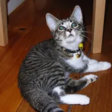

label=5 (cat)
Prediction: 5 (cat)


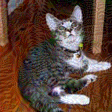

Prediction: 3 (bottle)


In [22]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

# Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

In [ ]:
class AdvPropDoubleBN(torch.nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.bn_plain = torch.nn.BatchNorm2d(num_features, eps=eps, momentum=momentum, affine=True, track_running_stats=True)
        self.bn_adv = torch.nn.BatchNorm2d(num_features, eps=eps, momentum=momentum, affine=True, track_running_stats=True)

        # Share weight and bias between bn_plain and bn_adv
        self.bn_adv.weight = self.bn_plain.weight
        self.bn_adv.bias = self.bn_plain.bias

        self.use_adv = False

    def forward(self, x):
        if self.training:
            if self.use_adv:
                return self.bn_adv(x)
            else:
                return self.bn_plain(x)
        else:
            return self.bn_plain(x)

    def set_adv_mode(self, adv: bool):
        self.use_adv = adv


def replace_bn_with_double_bn(model: torch.nn.Module) -> torch.nn.Module:
    for name, module in model.named_children():
        if isinstance(module, torch.nn.BatchNorm2d):
            new_module = AdvPropDoubleBN(module.num_features, module.eps, module.momentum)
            # Copy affine params and running stats from old BN to bn_plain
            new_module.bn_plain.weight.data.copy_(module.weight.data)
            new_module.bn_plain.bias.data.copy_(module.bias.data)
            new_module.bn_plain.running_mean.data.copy_(module.running_mean.data)
            new_module.bn_plain.running_var.data.copy_(module.running_var.data)
            if module.num_batches_tracked is not None:
                new_module.bn_plain.num_batches_tracked.data.copy_(module.num_batches_tracked.data)
            # ###
            # new_module.bn_adv.running_mean.data.copy_(module.running_mean.data)
            # new_module.bn_adv.running_var.data.copy_(module.running_var.data)
            # if module.num_batches_trackes is not None:
            #   new_module.bn_adv.num_batches.tracked.data.copy_(module.num_batches_tracked.data)
            # ###

            setattr(model, name, new_module)
        else:
            replace_bn_with_double_bn(module)
    return model


def set_adv_mode(model: torch.nn.Module, adv: bool):
    for m in model.modules():
        if isinstance(m, AdvPropDoubleBN):
            m.set_adv_mode(adv)

In [ ]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    def train_epoch(
        self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct_plain = 0
        n_correct_adv = 0
        n_total = 0

        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)
            optimizer.zero_grad()

            set_adv_mode(model, False)
            logits_plain = model(image_batch)
            plain_loss = torch.nn.CrossEntropyLoss()(logits_plain, label_batch)

            x_adv = adversarialPGD(
                model,
                unnormalize(image_batch),
                label_batch,
                epsilon=self.epsilon,
                alpha=self.alpha,
                n_iters=self.n_iters
            )
            x_adv = normalize(x_adv)

            # Adv forward
            set_adv_mode(model, True)
            logits_adv = model(x_adv)
            adv_loss = torch.nn.CrossEntropyLoss()(logits_adv, label_batch)

            # Combine losses: (1 - adv_ratio)*plain_loss + adv_ratio*adv_loss
            loss = (1.0 - self.adv_ratio) * plain_loss + self.adv_ratio * adv_loss
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                pred_plain = logits_plain.argmax(dim=1)
                pred_adv = logits_adv.argmax(dim=1)
                n_correct_plain += (pred_plain == label_batch).sum().item()
                n_correct_adv += (pred_adv == label_batch).sum().item()
                n_total += len(label_batch)

            plain_acc = n_correct_plain / n_total
            adv_acc = n_correct_adv / n_total
            progress_bar.set_postfix({
                "plain-acc": f"{plain_acc * 100:.1f} %",
                "adv-acc": f"{adv_acc * 100:.1f} %",
                "lr": optimizer.param_groups[0]["lr"]
            })

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, torch.utils.data.DataLoader]) -> dict[str, float]:
        # During evaluation, always use plain mode
        set_adv_mode(model, False)
        model.eval()
        result = dict[str, float]()
        with torch.no_grad():
            for k, d in eval_dataloaders.items():
                result[k] = evaluate(model, d, description=k, quiet=True)
                print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [ ]:
### BEGIN SOLUTION
# Train with regular Trainer
model_trainer = get_model(eval=False, reset=False)
trainer = Trainer(n_epochs=10, device="cuda")
results_trainer = trainer.train(model_trainer)
print("DefaultTrainer results:", results_trainer)

model_adv = get_model(eval=False, reset=False)
model_adv = replace_bn_with_double_bn(model_adv)
adv_trainer = AdvPropTrainer(
    n_epochs=10,
    device="cuda",
    n_iters=1,
    epsilon=4/255,
    alpha=2/255,
    adv_ratio=0.25
)
results_adv = adv_trainer.train(model_adv)
print("AdvPropTrainer results:", results_adv)
# ### END SOLUTION

val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=56.2 %, lr=0.0002]


val=90.7 %	alt=51.4 %	


Train epoch   2: 100%|██████████| 79/79 [01:09<00:00,  1.13it/s, train-acc=65.9 %, lr=0.000194]


val=90.3 %	alt=52.1 %	


Train epoch   3: 100%|██████████| 79/79 [01:10<00:00,  1.11it/s, train-acc=70.3 %, lr=0.000188]


val=90.4 %	alt=53.0 %	


Train epoch   4: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=73.4 %, lr=0.000183]


val=90.2 %	alt=53.8 %	


Train epoch   5: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=75.5 %, lr=0.000177]


val=91.8 %	alt=53.6 %	


Train epoch   6: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=76.6 %, lr=0.000172]


val=93.0 %	alt=53.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:15<00:00,  1.04it/s, train-acc=77.5 %, lr=0.000167]


val=93.6 %	alt=54.1 %	


Train epoch   8: 100%|██████████| 79/79 [01:12<00:00,  1.08it/s, train-acc=78.8 %, lr=0.000162]


val=93.9 %	alt=55.3 %	


Train epoch   9: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, train-acc=79.3 %, lr=0.000157]


val=93.5 %	alt=54.2 %	


Train epoch  10: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=79.7 %, lr=0.000152]


val=93.8 %	alt=53.3 %	
DefaultTrainer results: {'val': [0.873, 0.907, 0.903, 0.904, 0.902, 0.918, 0.93, 0.936, 0.939, 0.935, 0.938], 'alt': [0.43357142857142855, 0.5142857142857142, 0.5214285714285715, 0.53, 0.5378571428571428, 0.5357142857142857, 0.5360714285714285, 0.5414285714285715, 0.5528571428571428, 0.5425, 0.5332142857142858]}
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:31<00:00,  1.15s/it, plain-acc=55.9 %, adv-acc=30.5 %, lr=0.0002]


val=89.8 %	alt=53.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, plain-acc=64.9 %, adv-acc=33.5 %, lr=0.000194]


val=89.7 %	alt=53.1 %	


Train epoch   3: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, plain-acc=68.8 %, adv-acc=35.3 %, lr=0.000188]


val=89.7 %	alt=54.1 %	


Train epoch   4: 100%|██████████| 79/79 [01:24<00:00,  1.06s/it, plain-acc=72.1 %, adv-acc=37.2 %, lr=0.000183]


val=89.8 %	alt=54.5 %	


Train epoch   5: 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, plain-acc=73.7 %, adv-acc=38.3 %, lr=0.000177]


val=91.0 %	alt=55.3 %	


Train epoch   6: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, plain-acc=74.9 %, adv-acc=38.9 %, lr=0.000172]


val=91.9 %	alt=55.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, plain-acc=76.5 %, adv-acc=40.2 %, lr=0.000167]


val=91.7 %	alt=55.1 %	


Train epoch   8: 100%|██████████| 79/79 [01:34<00:00,  1.20s/it, plain-acc=77.1 %, adv-acc=41.1 %, lr=0.000162]


val=91.8 %	alt=54.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:34<00:00,  1.20s/it, plain-acc=78.3 %, adv-acc=42.2 %, lr=0.000157]


val=92.5 %	alt=54.1 %	


Train epoch  10: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, plain-acc=78.4 %, adv-acc=42.3 %, lr=0.000152]


val=92.1 %	alt=53.1 %	
AdvPropTrainer results: {'val': [0.873, 0.898, 0.897, 0.897, 0.898, 0.91, 0.919, 0.917, 0.918, 0.925, 0.921], 'alt': [0.43357142857142855, 0.5303571428571429, 0.5314285714285715, 0.5407142857142857, 0.5453571428571429, 0.5532142857142858, 0.5496428571428571, 0.5510714285714285, 0.5457142857142857, 0.5410714285714285, 0.5314285714285715]}


In [ ]:
val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
model_trainer.eval()
model_adv.eval()

with torch.no_grad():
    val_acc_trainer = evaluate(model_trainer, val_dataset, use_workers=False)
    val_acc_adv = evaluate(model_adv, val_dataset, use_workers=False)
    alt_acc_trainer = evaluate(model_trainer, alt_test_dataset, use_workers=False)
    alt_acc_adv = evaluate(model_adv, alt_test_dataset, use_workers=False)

print("")
print(f"Trainer val acc: {val_acc_trainer*100:.2f}% ;; Adv val acc: {val_acc_adv*100:.2f}%")
print(f"Trainer alt acc: {alt_acc_trainer*100:.2f}% ;; Adv alt acc: {alt_acc_adv*100:.2f}%")

eval: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s, accuracy=53.1 %]


Trainer val acc: 93.80% ;; Adv val acc: 92.10%
Trainer alt acc: 53.32% ;; Adv alt acc: 53.14%


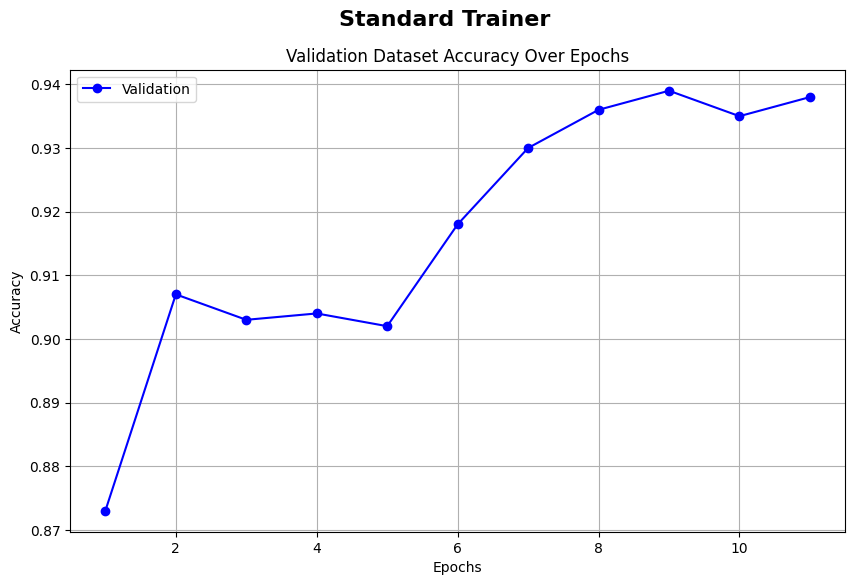

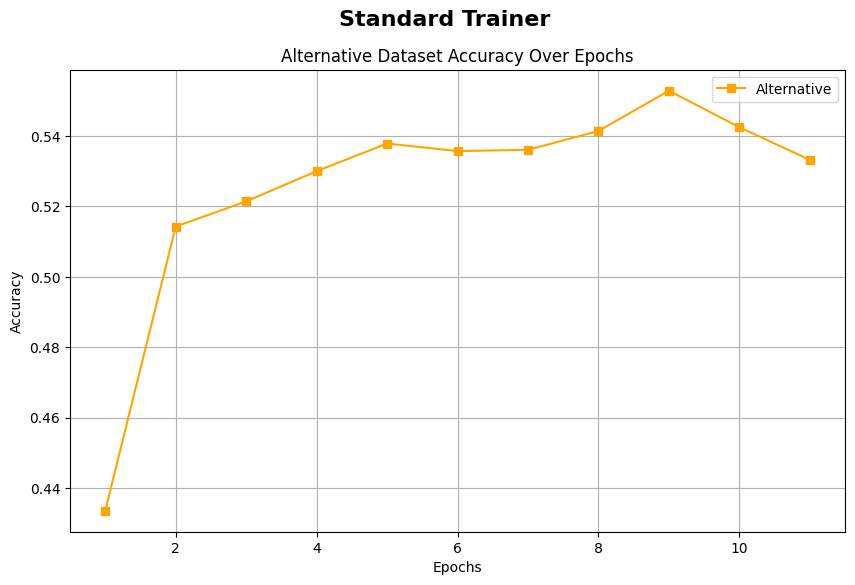

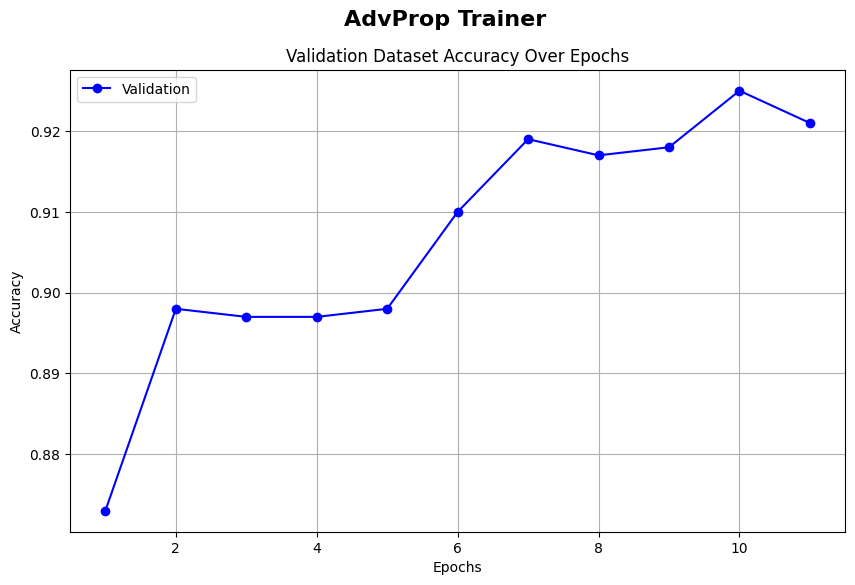

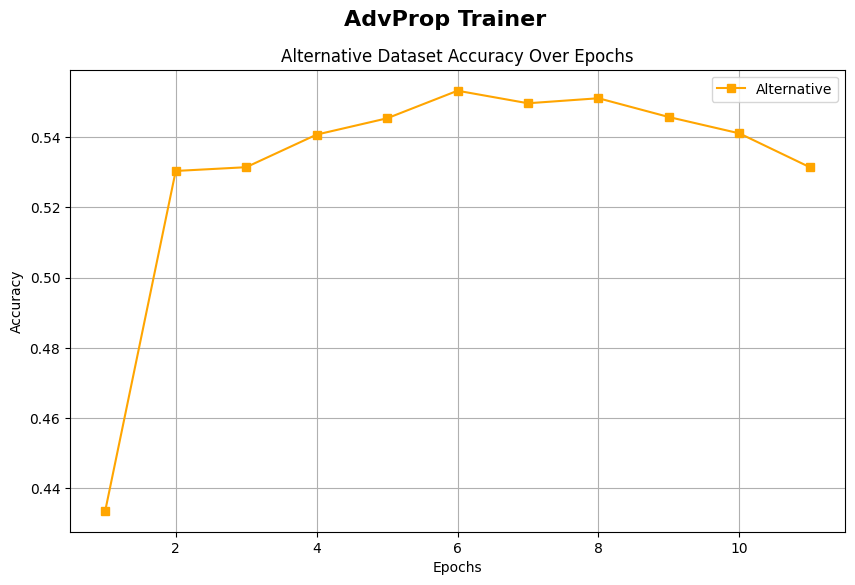

In [ ]:
epochs = list(range(1, len(results_trainer['val']) + 1))
# Plot for 'val'
plt.figure(figsize=(10, 6))
plt.plot(epochs, results_trainer['val'], marker='o', label='Validation', color='blue')
plt.suptitle('Standard Trainer', fontsize=16, fontweight='bold')
plt.title('Validation Dataset Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Plot for 'alt'
plt.figure(figsize=(10, 6))
plt.plot(epochs, results_trainer['alt'], marker='s', label='Alternative', color='orange')
plt.suptitle('Standard Trainer', fontsize=16, fontweight='bold')
plt.title('Alternative Dataset Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

epochs = list(range(1, len(results_adv['val']) + 1))
# Plot for 'val'
plt.figure(figsize=(10, 6))
plt.plot(epochs, results_adv['val'], marker='o', label='Validation', color='blue')
plt.suptitle('AdvProp Trainer', fontsize=16, fontweight='bold')
plt.title('Validation Dataset Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Plot for 'alt'
plt.figure(figsize=(10, 6))
plt.plot(epochs, results_adv['alt'], marker='s', label='Alternative', color='orange')
plt.suptitle('AdvProp Trainer', fontsize=16, fontweight='bold')
plt.title('Alternative Dataset Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Discussion
Validation Dataset:

- The Standard Trainer achieves a slightly higher peak accuracy (94%) compared to the AdvProp Trainer (92.5%).
- However, the accuracy curve for the AdvProp Trainer is more stable over epochs, with less fluctuation compared to the Standard Trainer.

Alternative Dataset:

- On the alternative dataset, the AdvProp Trainer consistently outperforms the Standard Trainer, achieving a higher peak accuracy (55%) compared to the Standard Trainer (54.5%).
- This suggests that the AdvProp Trainer is better at generalizing to datasets with altered styles, reducing over-reliance on textures.

## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION
        if self.k == 1.0:
          return x
        elif self.k == 0.0:
          return torch.zeros_like(x)

        abs_x = x.abs()
        abs_x_flat = abs_x.flatten(-2, -1)

        thresh = torch.quantile(abs_x_flat, 1 - self.k, dim=-1, keepdim=True)  # shape: (B..., C, 1)
        thresh = thresh.unsqueeze(-1)
        mask = abs_x >= thresh

        return x * mask
        ### END SOLUTION

def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=71.6 %	alt=31.9 %	


Train epoch   1: 100%|██████████| 79/79 [01:15<00:00,  1.05it/s, train-acc=39.8 %, lr=0.0002]


val=76.6 %	alt=46.6 %	


Train epoch   2: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=51.7 %, lr=0.000194]


val=82.0 %	alt=51.1 %	


Train epoch   3: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=57.5 %, lr=0.000188]


val=83.6 %	alt=52.2 %	


Train epoch   4: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=60.6 %, lr=0.000183]


val=83.7 %	alt=53.1 %	


Train epoch   5: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=63.6 %, lr=0.000177]


val=84.8 %	alt=53.9 %	


Train epoch   6: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=65.7 %, lr=0.000172]


val=85.7 %	alt=53.7 %	


Train epoch   7: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=66.9 %, lr=0.000167]


val=85.4 %	alt=54.8 %	


Train epoch   8: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=68.0 %, lr=0.000162]


val=85.2 %	alt=55.4 %	


Train epoch   9: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=69.2 %, lr=0.000157]


val=86.4 %	alt=55.8 %	


Train epoch  10: 100%|██████████| 79/79 [01:10<00:00,  1.13it/s, train-acc=70.6 %, lr=0.000152]


val=87.4 %	alt=55.1 %	


#### Discussion
The SparseTopK optimization introduces a unique trade-off compared to the Standard Trainer and AdvProp Trainer:

Validation Dataset:

- SparseTopK achieves a lower validation accuracy (87.4%) compared to both the Standard Trainer (94%) and AdvProp Trainer (92.5%), indicating it sacrifices performance on clean validation data.

Alternative Dataset:

- On the alternative dataset, SparseTopK achieves the highest accuracy (55.1%), surpassing both the AdvProp Trainer (55%) and the Standard Trainer (54.5%).
- This suggests SparseTopK optimization significantly improves robustness to restylized and texture-altered data, outperforming adversarial augmentation.